<h2>Training Feature Basis Functions</h2>

Here we seek to train a custom basis function feature for every control track. This way we can use just one feature for each control track while still capturing the unique biases present in each track. We do this using fused ridge regression to smooth out these basis functions.

<h3>Code</h3>

In [1]:
using PureSeq
using Gadfly
using DataStructures

In [2]:
function learn_feature(targetFile, controlFile, nbins; useReverseReads=false, maxCount=3200000000, keepDuplicates=false)
    targetReader = BamReader(targetFile, useReverseReads, ReferenceContigs_hg38)
    controlReader = BamReader(controlFile, useReverseReads, ReferenceContigs_hg38)
    P = 2*nbins + 1
    XtXcounts = zeros(Int64, P)
    Xty = zeros(Int64, P)
    targetValue = 0
    controlQueue = Deque{(Int64,Int64)}()
    tmp = Array(Int64, P)
    countTenth = int(maxCount/10)
    
    for i in 1:maxCount
        
        # remove old control positions that fell outside the sliding window
        while length(controlQueue) > 0 && front(controlQueue)[1] < i-nbins
            shift!(controlQueue)
        end
        
        # add new control positions in the sliding window
        if position(controlReader) != -1 && position(controlReader) <= i+nbins
            value = 0
            
            # get all the reads at this position
            pos = position(controlReader)
            while position(controlReader) == pos
                value += 1
                advance!(controlReader)
            end
            if !keepDuplicates
                value = 1
            end
            push!(controlQueue, (pos, value)) 
            
            # update XtXcount
            for (pos1,value1) in controlQueue
                XtXcounts[pos-pos1+1] += value*value1
            end
        end
        
        # get the current target count
        targetValue = 0
        while position(targetReader) == i
            targetValue += 1
            advance!(targetReader)
        end
        if !keepDuplicates && targetValue != 0
            targetValue = 1
        end
        
        # update Xty
        if targetValue != 0
            for (pos1,value1) in controlQueue
                Xty[pos1 - i + nbins + 1] += targetValue*value1
            end
        end
        
        if i % countTenth == 0
            println(i)
        end
    end
    
    close(targetReader)
    close(controlReader)
    
    XtXcounts, Xty
end

function build_XtX(XtXcounts)
    P = length(XtXcounts)
    XtX = zeros(Float64, P, P)
    for i in 1:P
        for j in i:P
            XtX[j,i] = XtX[i,j] = XtXcounts[j-i+1]
        end
    end
    XtX
end

function fused_ridge(XtX, Xty, lambda)
    P = length(Xty)
    D = eye(P)
    for i in 1:P-1
        D[i,i+1] = -1
    end
    D[P,P] /= lambda
    invD = inv(D)
    invD*inv(invD'XtX*invD .+ lambda*eye(P))*invD'Xty
end

function bin_values(arr, step)
    out = Float64[]
    for i = 1:step:length(arr)
        push!(out, mean(arr[i:min(i+step-1,length(arr))]))
    end
    out
end

bin_values (generic function with 1 method)

<h3>Compare different window sizes</h3>

How wide we make the basis functions should be driven by the length of dependency along the genome. Here we test multiple different lengths to see how the marginal correlation between a target position and a control position varies as the distance between target and control position increases.

<h4>60,001 base window</h4>

In [5]:
root = "/scratch2/slund1/ENCSR000BQS_notebook"
targetId = "ENCFF000NYK"
controlIds = ["ENCFF000ODO", "ENCFF000ODV"]
# XtXcounts_30k, Xty_30k = learn_feature(
#     "$root/$targetId.bam",
#     "$root/$(controlIds[1]).bam",
#     30000,
#     useReverseReads=false
# )
# open(f->write(f, XtXcounts_30k), "/tmp/XtXcounts_30k.jbin", "w")
# open(f->write(f, Xty_30k), "/tmp/Xty_30k.jbin", "w")
XtXcounts_30k_binned = bin_values(XtXcounts_30k, 100)
Xty_30k_binned = bin_values(Xty_30k, 100);

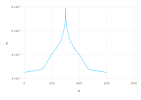

In [6]:
plot(x=1:length(Xty_30k_binned), y=Xty_30k_binned, Geom.line)

<h4>4,001 base window</h4>

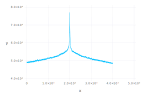

In [7]:
plot(x=1:4001, y=Xty_30k[30001-2000:30001+2000], Geom.line)

<h4>401 base window</h4>

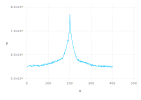

In [8]:
plot(x=1:401, y=Xty_30k[30001-200:30001+200], Geom.line)

<h3>Compare marginal vs. conditional association</h3>

While the marginal correlations plotted above show how the similarity between a target and control position decays with increasing distance, it does not show how important each position is for linear prediction. To do this we run a linear regression algorithm to estimate a $\beta_i$ for each distance $i$.

In the figures below it is apparent that while the similarity between a target position value and a control position extends a long ways through the genome, the additional predictive value of distant position is actually very small. In other words the information contained in the similarity of distant genomic positions with the target position is redundant with respect to the infornation provided by closer positions. This is good since it means we can use a smaller window size when building a feature basis function. Since the basis function will be used for prediction it is the predictive value of a distance position in which we are interested.

<h4>60,001 base window</h4>

Because $60,001 \times 60,001$ is a very large matrix we first downsample by a factor of $100$ before performing regression. This lowers the resolution, but helps prevent over fitting and makes the computation tractable.

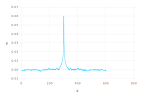

In [9]:
betas = inv(build_XtX(XtXcounts_30k_binned))*Xty_30k_binned
plot(x=1:length(betas), y=betas, Geom.line)

<h4>4,001 base window</h4>

In [ ]:
betas = inv(build_XtX(XtXcounts_30k[1:4001]))*Xty_30k[30001-2000:30001+2000]
plot(x=1:length(betas), y=betas, Geom.line)

<h4>401 base window</h4>

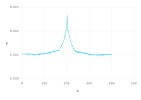

In [16]:
betas = inv(build_XtX(XtXcounts_30k[1:401]))*Xty_30k[30001-200:30001+200]
plot(x=1:length(betas), y=betas, Geom.line)

<h3>Fused ridge regression</h3>

Since we expect positions nearby each other to have similar predictive values it makes sense to regularize the functions to encourage values to be similar. This can be accomplished using Fused ridge regression as shown below for the $4,001$ base window.

In [ ]:
betas = fused_ridge(build_XtX(XtXcounts_30k[1:4001]), Xty_30k[30001-2000:30001+2000], 10e6)
plot(x=1:length(betas), y=betas, Geom.line)